<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Resnets_SVD_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating Full Jacobian SVD over the test data for ResNet data

Can do the full calculation, and a batched (slow, but handles large memory cases)

Can handle: ResnetXXX with CIFAR10, CIFAR100, SVHN

i.e. CIFAR 10
```
 resnet20_cifar10
 resnet56_cifar10
 resnet110_cifar10
 resnet164bn_cifar10
 resnet272bn_cifar10

full_jacobian()


 resnet542bn_cifar10
 resnet1001_cifar10
 resnet1202_cifar10

full_batched_jacobian()

```






In [5]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'

modelnames = ['resnet20_cifar100', 'resnet56_cifar100', 'resnet110_cifar100', 'resnet164bn_cifar100', 'resnet272bn_cifar100', 'resnet542bn_cifar100']
#modelnames = [thismodel]

num_classes = 100
num_data = 10000

batched = True
start_batch = 0
batch_size = 100

device = 'cuda:0'


time: 4.15 ms


In [6]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
time: 2.83 s


In [7]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.56 s


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 22.1 s


In [9]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

     |████████████████████████████████| 440kB 2.8MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=4dfa185775c5965b140b3a992db51354df1fce8c8486187c92548995f0a64a1c
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a7c5e0f272421976627135194db76c52869a21b1266468cb3a0e3293aaead140
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
time: 11.2 s


In [10]:
!import os
import time

import numpy as np
import pandas as pd
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


import matplotlib.pyplot as plt


/bin/bash: import: command not found
time: 1.76 s


### Run InstallPhysTheory notebook 

In [11]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 636 ms


In [12]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 49.1 ms


### Compute JJ, in batches or all at once


In [13]:
def get_datasets(thismodel, batch_size):
  print("getting dataset for ", thismodel)
  if thismodel.endswith('cifar100'):
    print("loading cifar100")
    train_dataset = datasets.CIFAR100(
      root='data', 
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
    test_dataset = datasets.CIFAR100(
      root='data', 
      train=False, 
      transform=transforms.ToTensor(),
      download=True) 
 
    train_loader = DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)
    test_loader = DataLoader(
      dataset=test_dataset, 
      batch_size=batch_size,
      num_workers=4,
      shuffle=False)

  else:
    print("loading cifar10")
    train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

      
  return train_dataset, test_dataset, train_loader, test_loader

time: 9.37 ms


In [14]:
train_dataset, test_dataset, train_loader, test_loader = get_datasets(modelnames[0], batch_size)#utils.get_data(batch_size=batch_size)
#train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

print(test_dataset)


getting dataset for  resnet20_cifar100
loading cifar100


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
time: 6.91 s


### Hook for model eval later

In [15]:
#model = ptcv_get_model(thismodel, pretrained=True)  

time: 870 µs


In [16]:
##3 TODO: check that files names are correctly ordered
def read_batched_JJMat(modelname, verbose=False):

  if verbose:
    print("Reading batched JJBlocks for ", modelname)
    
  JJMat = None
  import os, glob
  os.chdir(Jdir)
  for filename in glob.glob("Jfull_{}*".format(modelname)):
    if verbose:
      print(filename) 

    JJBlock = np.loadtxt(filename)
    JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

  return JJMat

time: 6.39 ms


In [42]:
for modelname in modelnames:
  print(modelname)
  JJMat = read_batched_JJMat(modelname, verbose=False)
  filename = "{}/JJMat_{}".format(Jdir, modelname)
  print(filename)
  np.save(filename, JJMat)

  #filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  #JJMat = np.load(filename)
  #print(type(JJMat))

resnet20_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100
resnet56_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100
resnet110_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100
resnet164bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100
resnet272bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100
resnet542bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100
time: 12min 55s


In [43]:
!ls  "$Jdir"/JJMat*cifar100.*

'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100.npy'
'/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100.npy'
time: 1.84 s


resnet20_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet20_cifar100.npy


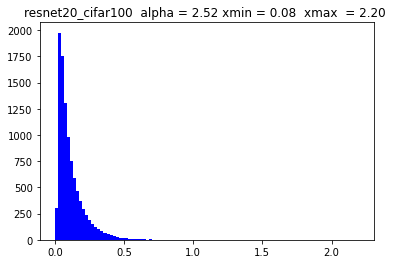

2.5209207887445038 0.10078424787833828 2.1994424642053234


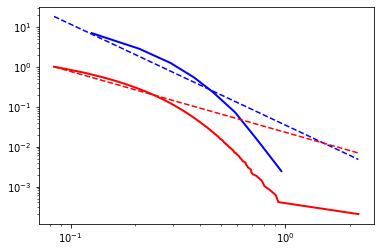

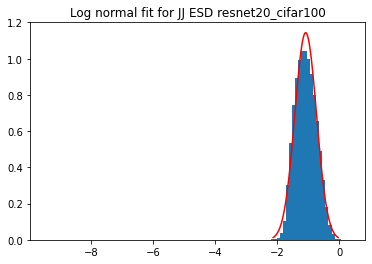

resnet56_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet56_cifar100.npy


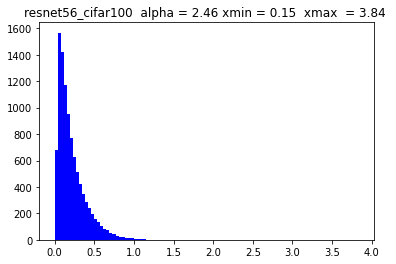

2.4590146881249164 0.117015366720849 3.840290049968956


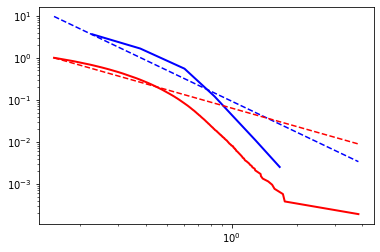

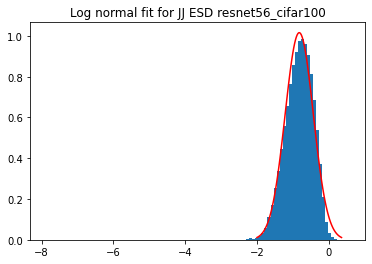

resnet110_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet110_cifar100.npy


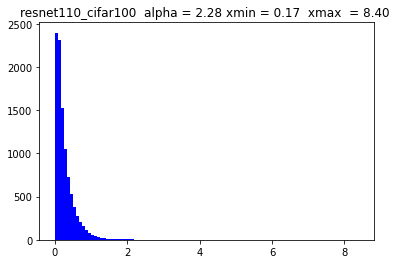

2.2817922849411287 0.1118265335063165 8.401701668299012


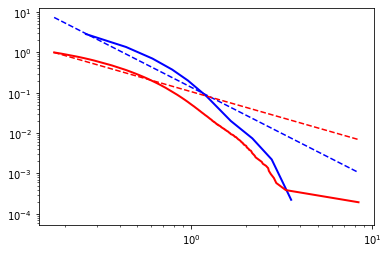

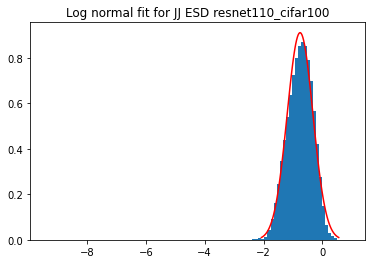

resnet164bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet164bn_cifar100.npy


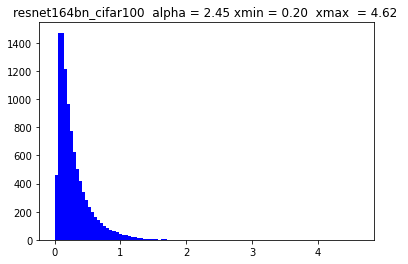

2.4463708137274027 0.10443212177648276 4.624204803801336


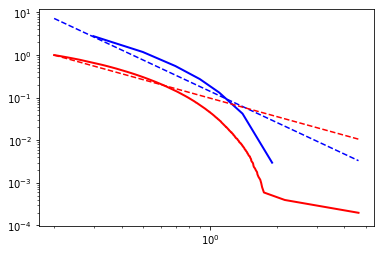

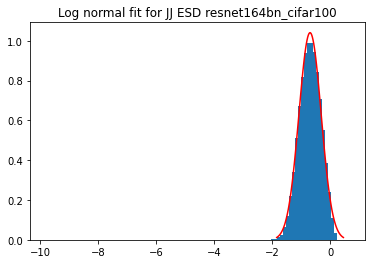

resnet272bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet272bn_cifar100.npy


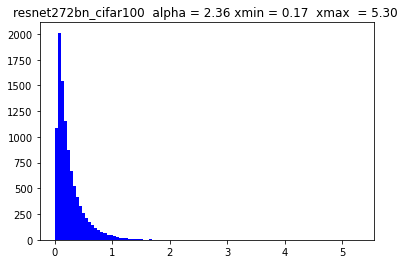

2.3607399363908925 0.10806035613067538 5.295448522689505


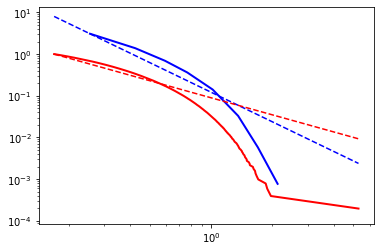

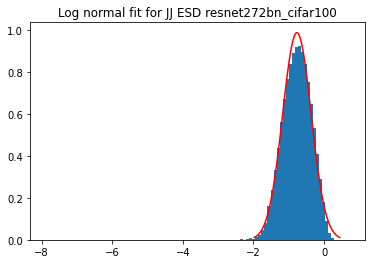

resnet542bn_cifar100
/content/drive/My Drive/J_resnets_fullsvd/JJMat_resnet542bn_cifar100.npy


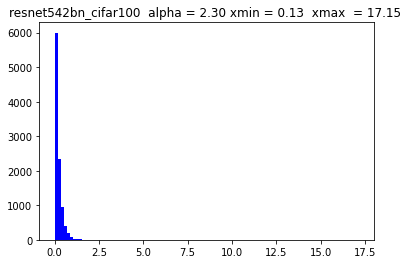

2.295072761565212 0.1103687254663756 17.14609459230052


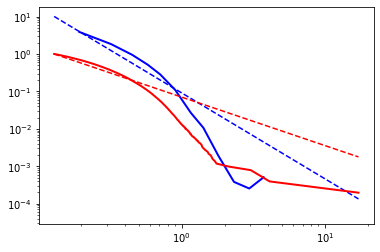

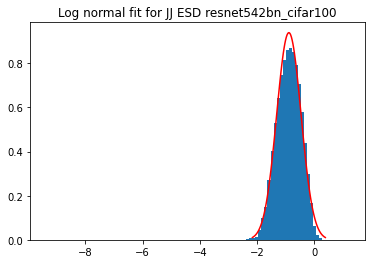

time: 13min 50s


In [50]:
import powerlaw

alphas = []
tail_alphas = []
max_evals = []
variances = []
JJnorms = []

for modelname in modelnames:
  print(modelname)
  filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  print(filename)
  JJMat = np.load(filename)

  JJMat =  (1.0/ norm)*JJMat
  JJnorms.append(np.linalg.norm(JJMat))

  norm = num_classes*3*32*32
  evals = np.linalg.eigh(JJMat)[0]   #LAPAK routine

  data = evals[evals > 0.0]
  logdata = np.log10(data)
  mu = np.mean(logdata)
  var = np.var(logdata)
  sigma = np.sqrt(var)

  xmin = 10**mu 

  fit = powerlaw.Fit(data, xmin=xmin)
  alpha = fit.alpha
  D = fit.D
  max_eval = np.max(evals)

  plt.hist(data, bins=100, color='b')
  plt.title("{}  alpha = {:0.2f} xmin = {:0.2f}  xmax  = {:0.2f} ".format(modelname, alpha, xmin, max_eval))
  plt.show()

  print(alpha, D, max_eval)
  alphas.append(alpha)
  max_evals.append(max_eval)
  variances.append(var)

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.show()


  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')

  plt.hist(logdata, bins=100, density=True);
  plt.title("Log normal fit for JJ ESD {}".format(modelname))
  plt.show()

  #fit = powerlaw.Fit(data, xmax=np.max(evals))
  #print("tail alpha = {:0.2f}".format(fit.alpha))
  #tail_alphas.append(fit.alpha)
  


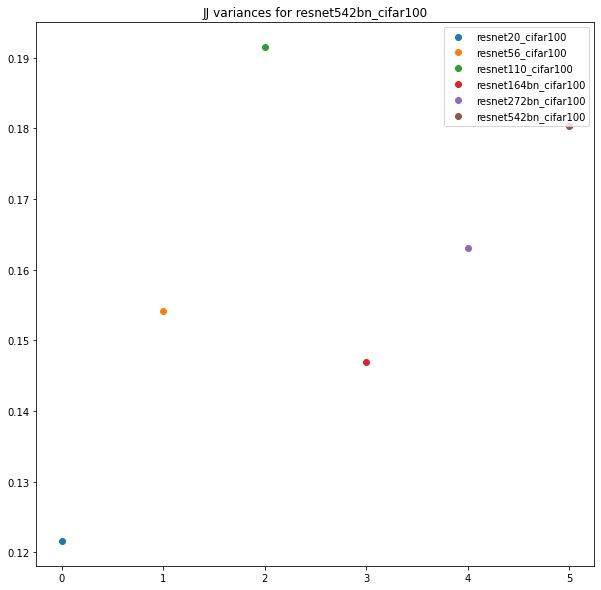

time: 235 ms


In [59]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, variances[im], label=modelname)
plt.title("JJ variances for {}".format(modelname))
plt.legend()
plt.show()

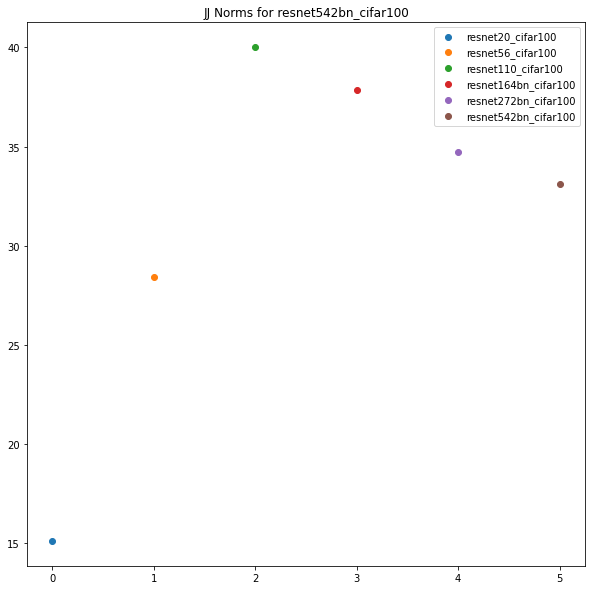

time: 231 ms


In [57]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, JJnorms[im], label=modelname)
plt.title("JJ Norms for {}".format(modelname))
plt.legend()
plt.show()

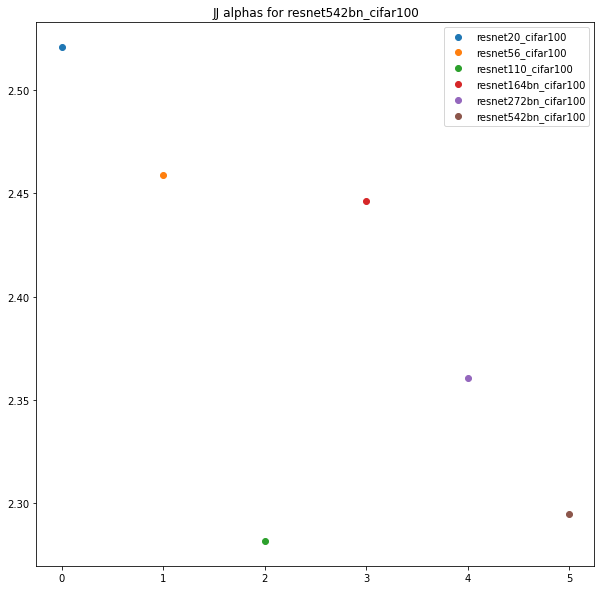

time: 232 ms


In [58]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, alphas[im], label=modelname)
plt.title(modelname)
plt.title("JJ alphas for {}".format(modelname))
plt.legend()
plt.show()

In [ ]:
xmin

resnet20_cifar100
4.305000168227714 0.13396139430571852


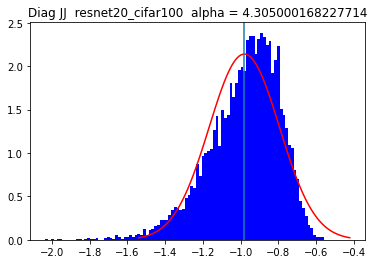

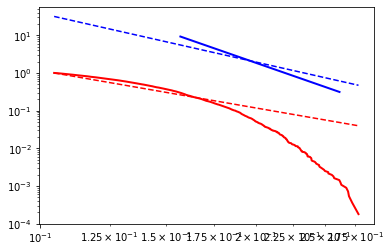

resnet56_cifar100
2.2614217905836567 0.2091276870015043


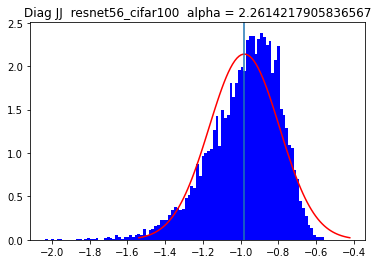

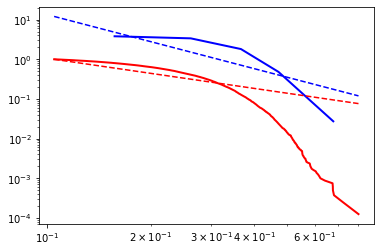

resnet110_cifar100
2.0338522295919774 0.18911070206217145


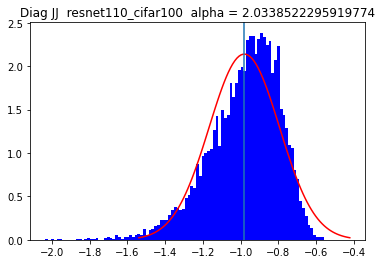

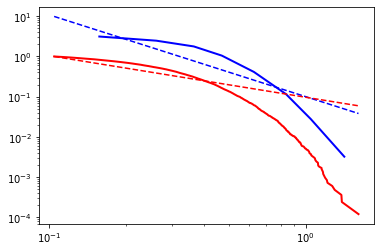

resnet164bn_cifar100
2.0446974228086177 0.20533950527504757


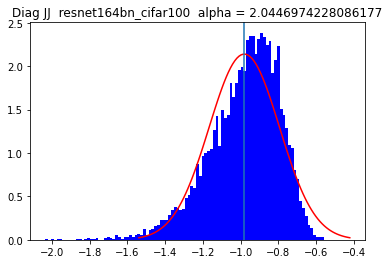

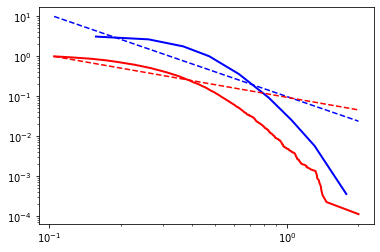

resnet272bn_cifar100
2.1231798907181068 0.17435480400437925


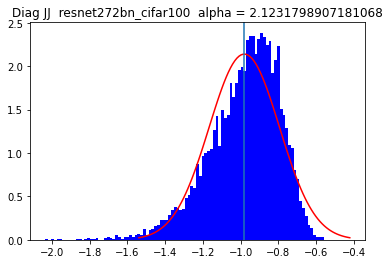

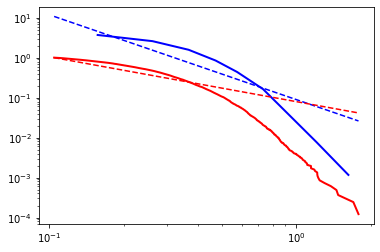

resnet542bn_cifar100
2.3351735501139395 0.15297642463312416


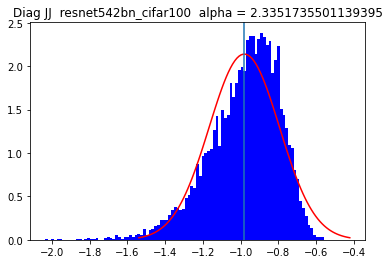

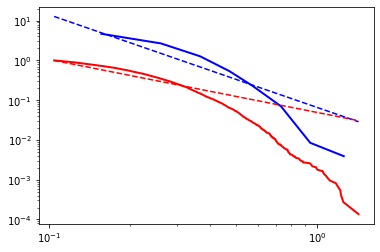

time: 11.9 s


In [88]:
diag_alphas = []

for modelname in modelnames:
  print(modelname)
  filename = "{}/JJMat_{}.npy".format(Jdir, modelname)
  JJMat = np.load(filename)
  JJMat =  (1.0/ norm)*JJMat

  JJDiag = np.diag(JJMat)
  data = JJDiag[JJDiag > 0.0]
  mu = np.mean(logdata)
  var = np.var(logdata)
  sigma = np.sqrt(var)

  xmin = 10**mu
  fit = powerlaw.Fit(data, xmin=xmin)

  alpha = fit.alpha
  D = fit.D
  diag_alphas.append(alpha)
  print(alpha, D)

  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r')

  plt.hist(logdata, bins=100, color='b', density=True)
  plt.axvline(x=mu)
  plt.title("Diag JJ  {}  alpha = {}".format(modelname,alpha))
  plt.show()

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.show()

  

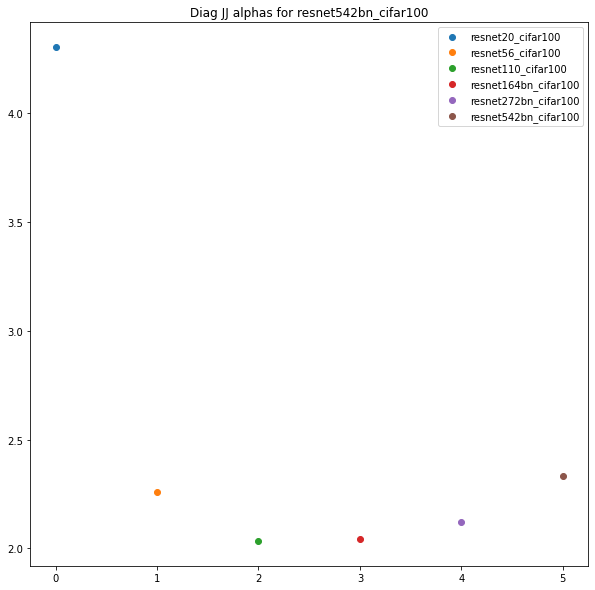

time: 234 ms


In [89]:
plt.figure(figsize=(10,10))
for im, modelname in enumerate(modelnames):
  plt.scatter(im, diag_alphas[im], label=modelname)
plt.title(modelname)
plt.title("Diag JJ alphas for {}".format(modelname))
plt.legend()
plt.show()